## 6b Calculate binned gradient-network overlap

#### This file works out the average z-score inside a gradient percentile area

##### written by Jan Freyberg for the Brainhack 2017 Project_

This should reproduce [this analysis](https://github.com/NeuroanatomyAndConnectivity/gradient_analysis/blob/master/05_metaanalysis_neurosynth.ipynb)

In [1]:
% matplotlib inline 

from __future__ import print_function

import nibabel as nib
from nilearn.image import resample_img

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import os.path

# The following are a progress bar, these are not strictly necessary:
from ipywidgets import FloatProgress
from IPython.display import display

Define the variables for this analysis. 
1. how many percentiles the data is divided into
2. where the Z-Maps (from neurosynth) lie
3. where the binned gradient maps lie
4. where a mask of the brain lies (not used at the moment).

In [20]:
percentiles = range(10)

# unthresholded z-maps from neurosynth:
zmaps = [os.path.join(os.getcwd(), 'ROIs_Mask', fname) for fname in os.listdir(os.path.join(os.getcwd(), 'ROIs_Mask'))
         if 'z.nii' in fname]

# individual, binned gradient maps, in a list of lists:
gradmaps = [[os.path.join(os.getcwd(), 'data', 'Outputs', 'Bins', str(percentile), fname)
             for fname in os.listdir(os.path.join(os.getcwd(), 'data', 'Outputs', 'Bins', str(percentile)))]
            for percentile in percentiles]

# a brain mask file:
brainmaskfile = os.path.join(os.getcwd(), 'ROIs_Mask', 'rbgmask.nii')

Next define a function to take the average of an image inside a mask and return it:

In [22]:
def zinsidemask(zmap, mask):
    # 
    zaverage = zmap.dataobj[
        np.logical_and(np.not_equal(mask.dataobj, 0), brainmask.dataobj>0)
    ].mean()
    return zaverage

This next cell will step through each combination of gradient, subject and network file to calculate the average z-score inside the mask defined by the gradient percentile. This will take a long time to run!

In [23]:
zaverages = np.zeros([len(zmaps), len(gradmaps), len(gradmaps[0])])

# load first gradmap just for resampling
gradmap = nib.load(gradmaps[0][0])

# Load a brainmask
brainmask = nib.load(brainmaskfile)
brainmask = resample_img(brainmask, target_affine=gradmap.affine, target_shape=gradmap.shape)

# Initialise a progress bar:
progbar = FloatProgress(min=0, max=zaverages.size)
display(progbar)

# loop through the network files:
for i1, zmapfile in enumerate(zmaps):
    # load the neurosynth activation file:
    zmap = nib.load(zmapfile)
    # make sure the images are in the same space:
    zmap = resample_img(zmap,
                        target_affine=gradmap.affine,
                        target_shape=gradmap.shape)
    # loop through the bins:
    for i2, percentile in enumerate(percentiles):
        # loop through the subjects:
        for i3, gradmapfile in enumerate(gradmaps[percentile]):
            gradmap = nib.load(gradmapfile)  # load image
            zaverages[i1, i2, i3] = zinsidemask(zmap, gradmap)  # calculate av. z-score
            progbar.value += 1  # update progressbar (only works in jupyter notebooks)


To save time next time, we'll save the result of this to file:

In [5]:
# np.save(os.path.join(os.getcwd(), 'data', 'average-abs-z-scores'), zaverages)

In [26]:
zaverages = np.load(os.path.join(os.getcwd(), 'data', 'average-z-scores.npy'))

Extract a list of which group contains which participants.

In [27]:
df_phen = pd.read_csv('data' + os.sep + 'SelectedSubjects.csv')
diagnosis = df_phen.loc[:, 'DX_GROUP']
fileids = df_phen.loc[:, 'FILE_ID']

groupvec = np.zeros(len(gradmaps[0]))
for filenum, filename in enumerate(gradmaps[0]):
    fileid = os.path.split(filename)[-1][5:-22]
    groupvec[filenum] = (diagnosis[fileids.str.contains(fileid)])

print(groupvec.shape)

(160,)


Make a plot of the z-scores inside each parcel for each gradient, split by group!

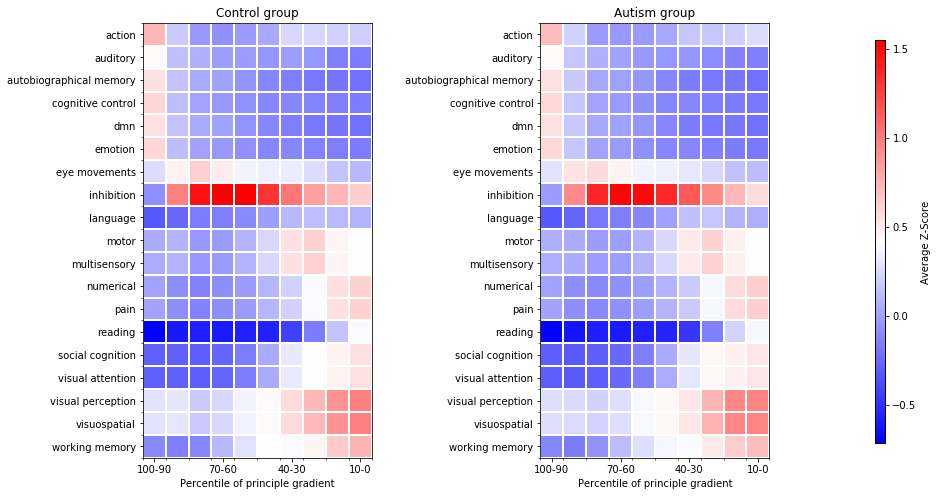

In [58]:
fig = plt.figure(figsize=(15, 8))
grouplabels = ['Control group', 'Autism group']
for group in np.unique(groupvec):
    
    ylabels = [os.path.split(fname)[-1][0:-23].replace('_', ' ') for fname in zmaps]
    # remove duplicates!
    includenetworks = []
    seen = set()
    for string in ylabels:
        includenetworks.append(string not in seen)
        seen.add(string)
    
    ylabels = [string for index, string in enumerate(ylabels) if includenetworks[index]]
    
    tmp_zaverages = zaverages[includenetworks, :, :]
    tmp_zaverages = tmp_zaverages[:, :, groupvec==group]
    
    tmp_zaverages = tmp_zaverages[np.argsort(np.argmax(tmp_zaverages.mean(axis=2), axis=1)), :, :]
    
    # make the figure
    plt.subplot(1, 2, group)
    cax = plt.imshow(tmp_zaverages.mean(axis=2),
               cmap='bwr', interpolation='nearest',
               vmin=zaverages.mean(axis=2).min(),
               vmax=zaverages.mean(axis=2).max())
    
    ax = plt.gca()
    plt.title(grouplabels[int(group-1)])

    plt.xlabel('Percentile of principle gradient')
    ax.set_xticks(np.arange(0, len(percentiles), 3))
    ax.set_xticklabels(['100-90', '70-60', '40-30', '10-0'])
    
    ax.set_yticks(np.arange(0, len(seen), 1))
    ax.set_yticklabels(ylabels)

    ax.set_yticks(np.arange(-0.5, len(seen), 1), minor=True)
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax.grid(which='minor', color='w', linewidth=2)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(cax, cax=cbar_ax, label='Average Z-Score')
    #fig.colorbar(cax, cmap='bwr', orientation='horizontal')

plt.savefig('./figures/z-scores-inside-gradient-bins.png')